In [1]:
import pandas as pd
import numpy as np

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [2]:
try:
    data_taxi=pd.read_csv('desktop/datasets/taxi.csv',index_col=[0], parse_dates=[0])
except:
    data_taxi=pd.read_csv('/datasets/taxi.csv',index_col=[0], parse_dates=[0])

data_taxi.head() 

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [3]:
#посмотрим основную информацию о временных рядах
data_taxi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [4]:
data_taxi['num_orders'].describe()

count    26496.000000
mean        14.070463
std          9.211330
min          0.000000
25%          8.000000
50%         13.000000
75%         19.000000
max        119.000000
Name: num_orders, dtype: float64

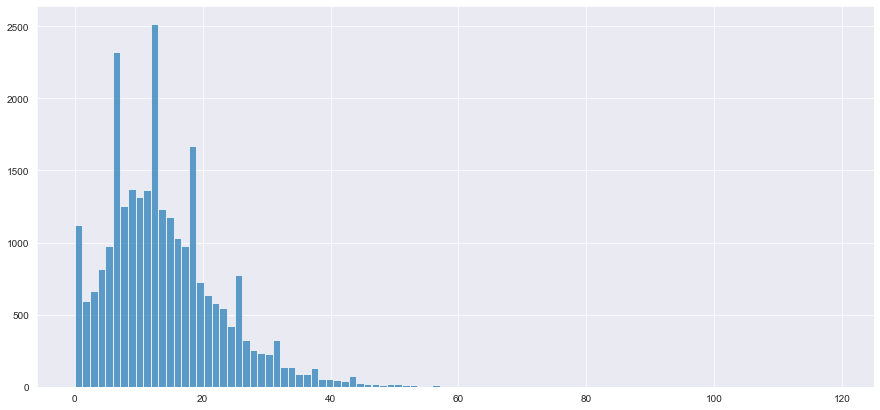

In [5]:
sns.set_style('darkgrid')  
data_taxi['num_orders'].hist(bins=100,figsize=[15,7],alpha=0.7)
plt.title('Распределение данных')
plt.show()

In [6]:
#resampling
data_taxi_resample = data_taxi.resample('1H').sum()

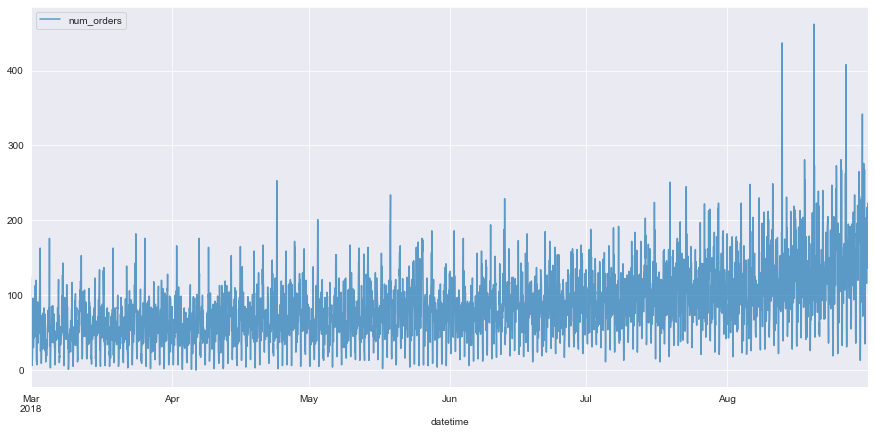

In [7]:
#посмотрим на данные
sns.set_style('darkgrid')  
plt.title('Общее представление данных')
data_taxi_resample.plot(figsize=[15,7],alpha=0.7)
plt.show()

<b>Вывод по изучению данных:</b>

Была проведена обработка данных для временного ряда, в рамках которого:

- был преобразован столбец с датами в index, преобразован его формат;
- проведен ресемплинг с диапозоном в 1 час, данные агрегировали с помощью суммы

### Анализ

In [8]:
#тест Дики — Фуллера (проверяем на стационарность)
test=adfuller(data_taxi_resample['num_orders'])
print('p-value = ', test[1])
print('adf:', test[0])
print ('Critical values:', test[4])
if test[0]>test[4]['5%']:
    print('есть единичные корни, ряд НЕ стационарен')
else:
    print('едичиных корней нет,ряд СТАЦИОНАРЕН')

p-value =  0.028940051402614374
adf: -3.068924289027937
Critical values: {'1%': -3.431842162413052, '5%': -2.8621993540813637, '10%': -2.567120978470452}
едичиных корней нет,ряд СТАЦИОНАРЕН


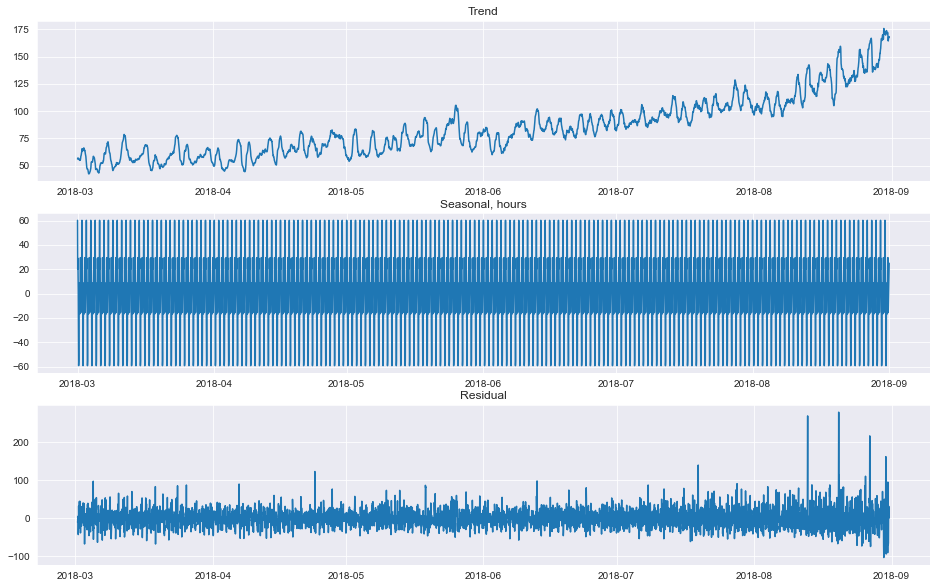

In [9]:
#разложим ряды, создадим функцию

def decompose_plot(data):
    fig, axs = plt.subplots(3, figsize=(16,10))
    axs[0].plot(data.trend)
    axs[0].set_title('Trend')

    axs[1].plot(data.seasonal)
    axs[1].set_title('Seasonal, hours')

    axs[2].plot(data.resid)
    axs[2].set_title('Residual')

    plt.show()

decomposed_data_taxi = seasonal_decompose(data_taxi_resample)

#разложим ряд на компоненты
decompose_plot(decomposed_data_taxi)

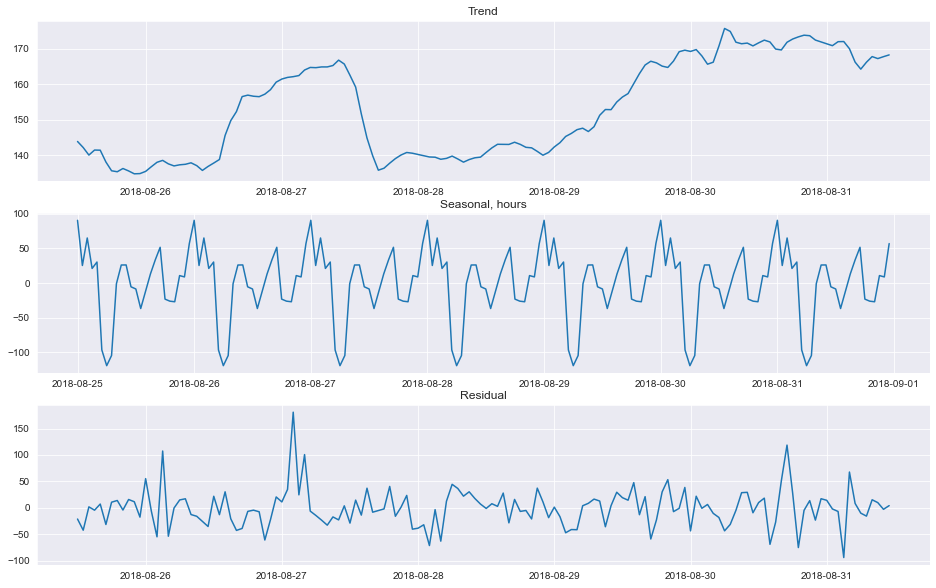

In [10]:
#разложим за последнюю неделю
decomposed_last_week = seasonal_decompose(data_taxi_resample['2018-08-25':'2018-08-31'])

decompose_plot(decomposed_last_week)

#### Roling Mean

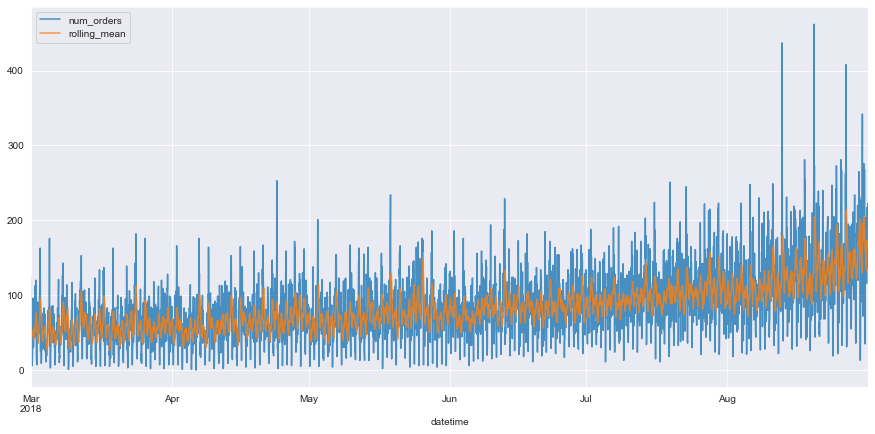

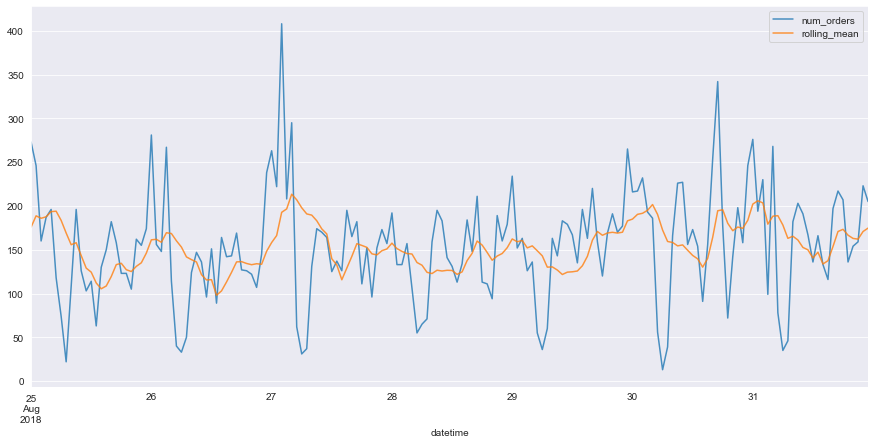

In [11]:
data_taxi_resample['rolling_mean'] = data_taxi_resample.rolling(10).mean()

#посмотрим на данные 
sns.set_style('darkgrid')  
plt.title('Распределение данных+скользящее среднее')
data_taxi_resample.plot(figsize=[15,7],alpha=0.8)
plt.show()

#посмотрим на данные за последнюю неделю
sns.set_style('darkgrid')  
plt.title('Распределение данных+скользящее среднее за неделю')
data_taxi_resample['2018-08-25':'2018-08-31'].plot(figsize=[15,7],alpha=0.8)
plt.show()

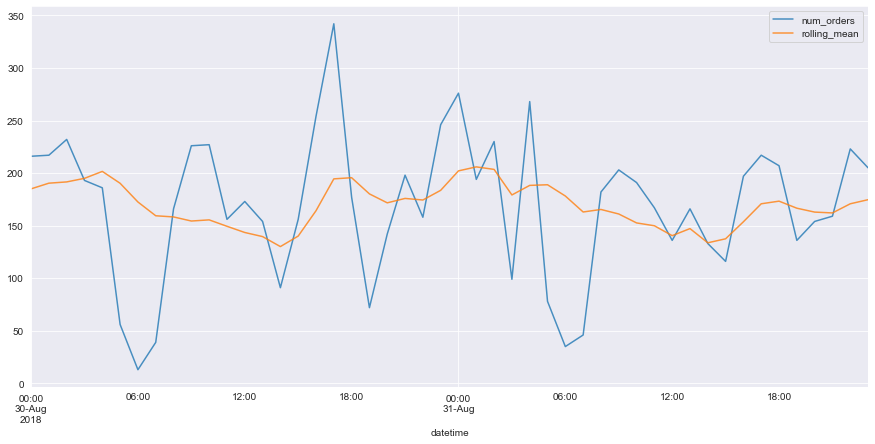

In [12]:
#посмотрим на данные за сутки
sns.set_style('darkgrid')  
plt.title('Распределение данных+скользящее среднее за сутки')
data_taxi_resample['2018-08-30':'2018-08-31'].plot(figsize=[15,7],alpha=0.8)
plt.show()

In [13]:
data_taxi_resample=data_taxi_resample.drop(['rolling_mean'],axis=1)

<b>Вывод по анализу ряда:</b>
Был проведе тест Дики-Фуллера, в результате которого установлено, что p-value =  0.02<0.05, заданного порога значимости, соответсвенно ряд стационарен.

Проанализировав данные, следует сделан вывод, что:
1. С апреля растет количество заказов
2.  В дневное рабочее время спрос стабильный, всплески ночью около 0:00, затем перед 18:00.

### Обучение

In [14]:
#создаем признаки
def make_features(data, max_lag, rolling_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

#мы выбрали произвольные значения аргументов
make_features(data_taxi_resample, 24, 4)

train, test = train_test_split(data_taxi_resample, shuffle=False, test_size=0.1)
train = train.dropna()


In [15]:
#разделим на признаки и целевую
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
 
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

#### Linear Regression

In [16]:
%%time
#обучение модели
lr_regressor = LinearRegression()

param_lr = {'fit_intercept':[True,False], 
            'copy_X':[True, False], 
                }

model_lg = GridSearchCV(lr_regressor,
                        param_grid = param_lr,
                        scoring='neg_mean_squared_error',
                        cv=5) 

model_lg.fit(features_train, target_train)


CPU times: user 376 ms, sys: 5.35 ms, total: 381 ms
Wall time: 100 ms


GridSearchCV(cv=5, estimator=LinearRegression(),
             param_grid={'copy_X': [True, False],
                         'fit_intercept': [True, False]},
             scoring='neg_mean_squared_error')

In [17]:
#лучшие параметры LGBM
print('Лучшие параметры для LinearRegression',model_lg.best_params_)

Лучшие параметры для LinearRegression {'copy_X': True, 'fit_intercept': False}


In [18]:
#RMSE для LGBM
print('Лучшее значение RMSE для LinearRegression')
print((model_lg.best_score_*(-1))**0.5)

Лучшее значение RMSE для LinearRegression
26.144381855485214


#### LightGBM

In [19]:
%%time

lgb_regressor=LGBMRegressor()

lgb_param = {'max_depth' : [3, 6, 10],
                'learning_rate' : [0.03, 0.1],
                'n_estimators' : [100,200,300]
               }

#обучаем
lgb_model = GridSearchCV(lgb_regressor, 
                               param_grid =lgb_param,
                               scoring='neg_mean_squared_error', 
                               cv=5)

lgb_model.fit(features_train, target_train)


CPU times: user 1min 14s, sys: 988 ms, total: 1min 15s
Wall time: 9.85 s


GridSearchCV(cv=5, estimator=LGBMRegressor(),
             param_grid={'learning_rate': [0.03, 0.1], 'max_depth': [3, 6, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='neg_mean_squared_error')

In [20]:
#лучшие параметры LGBM
print('Лучшие параметры для LightGBM',lgb_model.best_params_)

Лучшие параметры для LightGBM {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100}


In [21]:
#RMSE для LGBM
print('Лучшее значение RMSE для LightGBM')
print((lgb_model.best_score_*(-1))**0.5)

Лучшее значение RMSE для LightGBM
24.317351489089152


### Тестирование

In [22]:
#### LinearRegression

In [23]:
%%time
#Лучшая LinearRegression
best_linear = model_lg.best_estimator_

#предсказываем
linear_predict = best_linear.predict(features_test)

#финальный RMSE на LinearRegression
print(mean_squared_error(target_test, linear_predict, squared=False))

45.5293370802087


In [24]:
#### LightGBM 

In [25]:
%%time
#Лучшая модель LightGBM 
best_lgbm = lgb_model.best_estimator_

#предсказываем
lgbm_predict = best_lgbm.predict(features_test)

#финальный RMSE на тесте
print(mean_squared_error(target_test, lgbm_predict, squared=False))

42.62132454998988


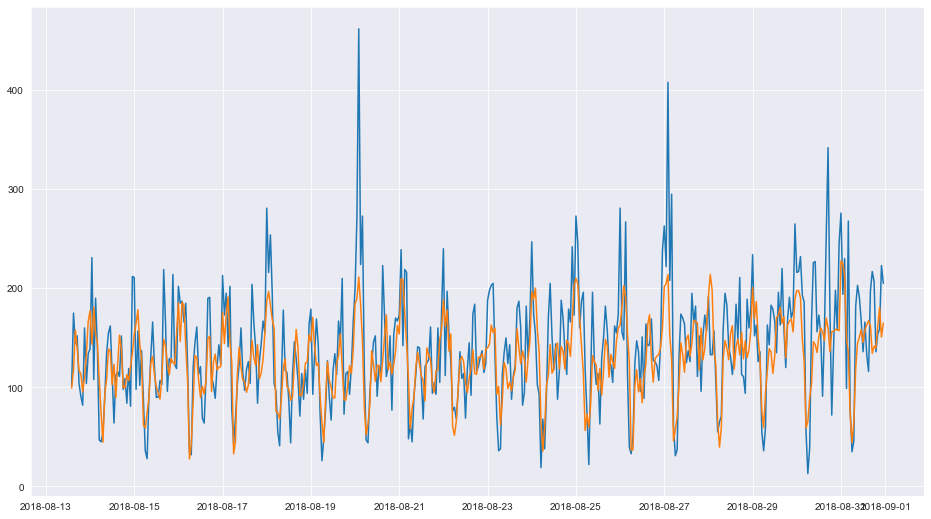

In [26]:
#смотрим на лучшей модели визуализацию по предсказанию
visual_frame = {'Target':target_test, 'Prediction':lgbm_predict}
result = pd.DataFrame(visual_frame) 

#графики
plt.figure(figsize=(16,9))
plt.title('Визуализация предсказания')
plt.plot(result);

<b>Выводы:</b>

1. Проведено предварительное изучение данных и их арнализ, в результате которого установлено, что:
- ряд стационарен (на основе теста Дики-Фуллера)
- с апреля растет количество заказов
- в дневное рабочее время спрос стабильный, всплески наблюдаются ночью около 0:00, затем перед 18:00. Это можно соотнести с окончанием рабочего дня в офисах в 18:00 и с тем, что после 0:00 возвращаются домой люди, которые не садятся за руль в позднее время

2. Проведено обучение моделей с различными гиперпараметрами, в частности сравнивались модели: 
- LinearRegression
- LightGBM

В результате установлено, что LightGBM показывает на тесте и обучении лучшие парметры () по времени и RMSE. Так же были визуализированы данные, для визуальной оценки качетсва предсказания (по лучшей модели)

